# Import of libraries


In [1]:
# pandas
import pandas as pd

# sklearn
import sklearn

# math
import math

#seaborn
import seaborn as sns

# sklearn (pre)processing & pipeline
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

#sklearn metrics & curves
from sklearn.metrics import  recall_score, precision_score, precision_recall_curve, roc_curve, roc_auc_score, classification_report
from sklearn.calibration import calibration_curve

#sklearn Classifier models
from sklearn.linear_model import LogisticRegression     #LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier      #Nearest Neighbor
#from sklearn.svm import SVC                             #Support Vector Machine
#from sklearn.tree import DecisionTreeClassifier         #Decision Tree
#from sklearn.ensemble import RandomForestClassifier     #Random Forest
#from sklearn.naive_bayes import GaussianNB              #Naive Bayes
#from sklearn.ensemble import GradientBoostingClassifier #Gradient Boosting

#mathplot
import matplotlib.pyplot as plt


# Description of the data
## Variables Table

| Variable Name | Role | Type | Demographic | Description | Units | Missing Values |
|---------------|------|------|-------------|-------------|-------|----------------|
| age           | Feature | Integer | Age | | | no |
| job | Feature | Categorical | Occupation | type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown') | | no |
| marital | Feature | Categorical | Marital Status | marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed) | | no |
| education | Feature | Categorical | Education Level | (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown') | | no |
| default | Feature | Binary | | has credit in default? | | no |
| balance | Feature | Integer | | average yearly balance | euros | no 
| housing | Feature | Binary | | has housing loan? | | no |
| loan | Feature | Binary | | has personal loan? | | no |
| contact | Feature | Categorical | | contact communication type (categorical: 'cellular','telephone') | | yes |
| day_of_week | Feature | Date | | last contact day of the week | | no |
| month | Feature	 | Date | | last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec') | | no |
| duration | Feature | Integer | | last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model. | | no |
| campaign | Feature | Integer | | number of contacts performed during this campaign and for this client (numeric, includes last contact) | | no |
| pdays | Feature | Integer | | number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted) | | yes |
| previous | Feature | Integer | | number of contacts performed before this campaign and for this client | | no |
| poutcome | Feature | Categorical | | outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success') | | yes |
| emp.var.rate | Feature | float64 | | Employment variation rate, with a quarterly frequency | | no |
| cons.price.idx | Feature | float64 | | Monthly average consumer price index | | no |
| cons.conf.idx | Feature | float64 | | Monthly average consumer confidence index | | no |
| euribor3m | Feature | float64 | | Daily three month Euribor rate | | no |
| nr.employed | Feature | float64 | | Quarterly average of the total number of employed citizens | | no |
| y	| Target | Binary | | has the client subscribed a term deposit? | | |

# Import of Data

In [2]:
# Inladen met de juiste scheidingstekens
# bank_data_small = pd.read_csv('../../Data/bank-additional/bank-additional.csv', sep=';')
bank_data_full = pd.read_csv('../../Data/bank-additional/bank-additional-full.csv', sep=';')

In [3]:
# Based on the Variables Table (see above) the column 'duration' will not be used for predictive purposes
bank_data_full = bank_data_full.drop("duration", axis='columns')

In [4]:
bank_data_full.describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [5]:
bank_data_full.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [6]:
bank_data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  euribor3m       41188 non-null 

In [7]:
bank_data_full.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [8]:
print("Continuous Variables: ")
continous_vars=bank_data_full.describe().columns  #get the names of numerical variables, in this case continuous variables
print(continous_vars)

print("\nCategorical Variables: ")
categorical_vars=bank_data_full.describe(include=[object]).columns
print(categorical_vars)

Continuous Variables: 
Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

Categorical Variables: 
Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object')


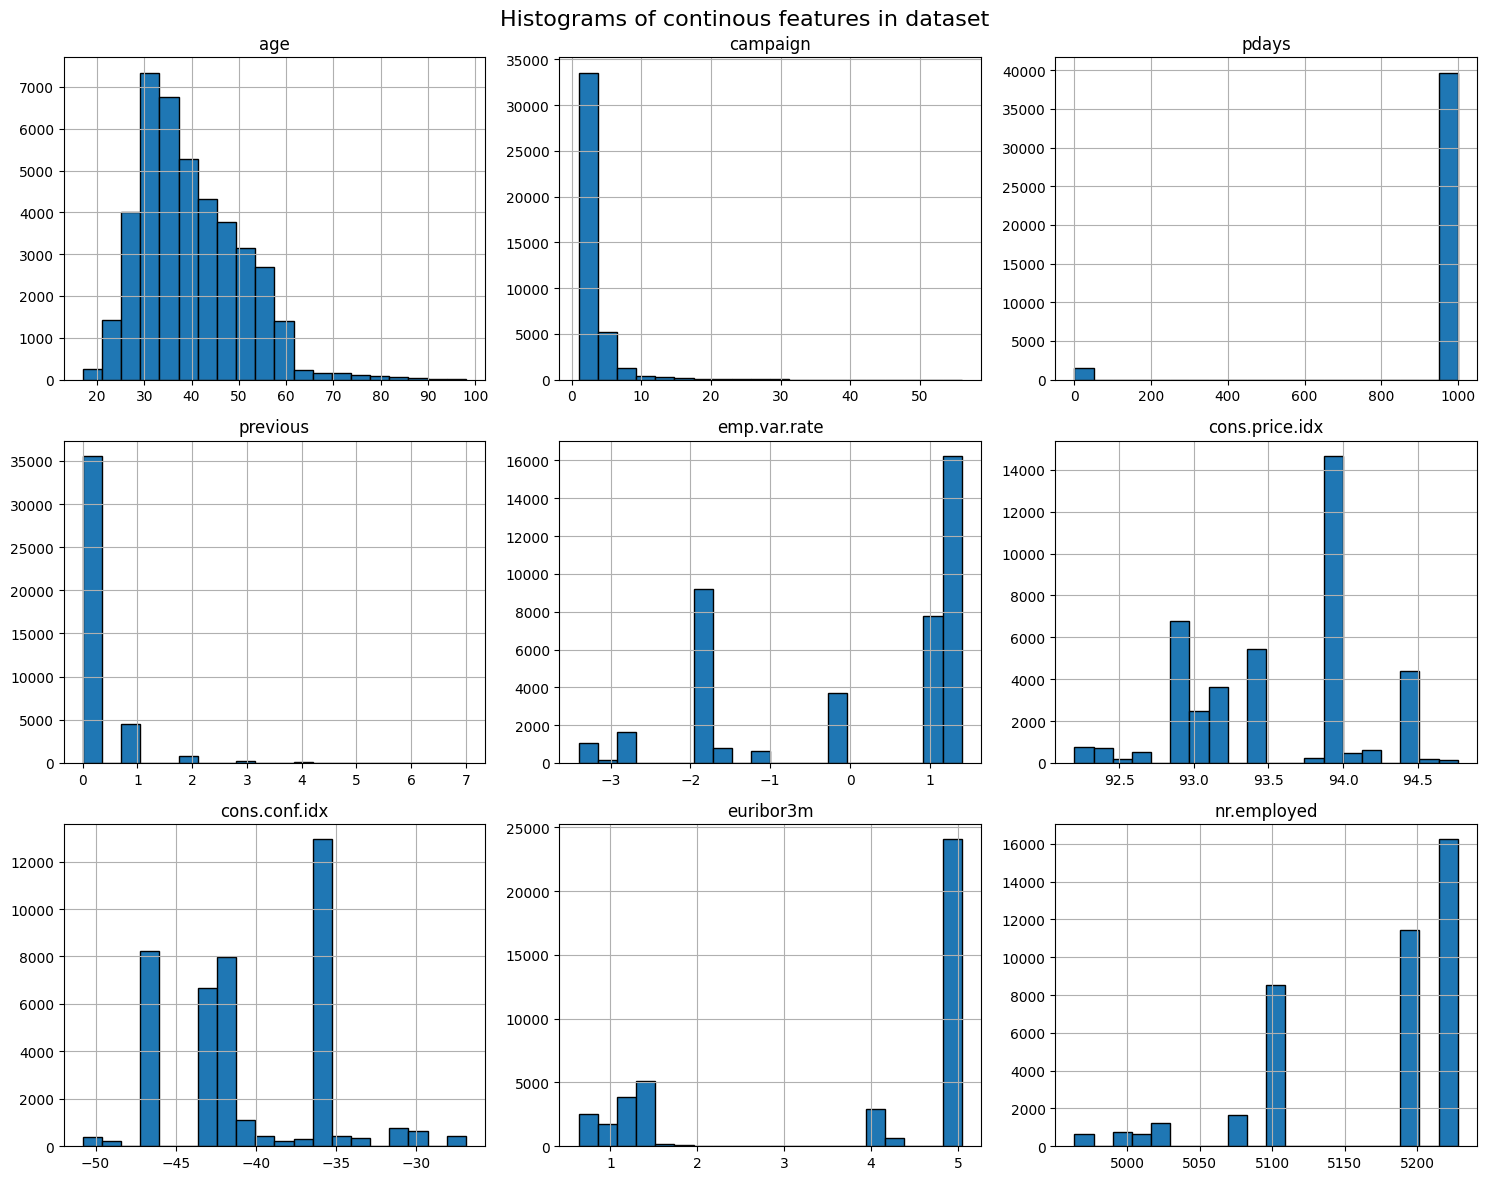

In [9]:
bank_data_full.hist(column=continous_vars, bins=20, figsize=(15, 12), edgecolor="black")
plt.suptitle("Histograms of continous features in dataset", fontsize=16)
plt.tight_layout()
plt.show()

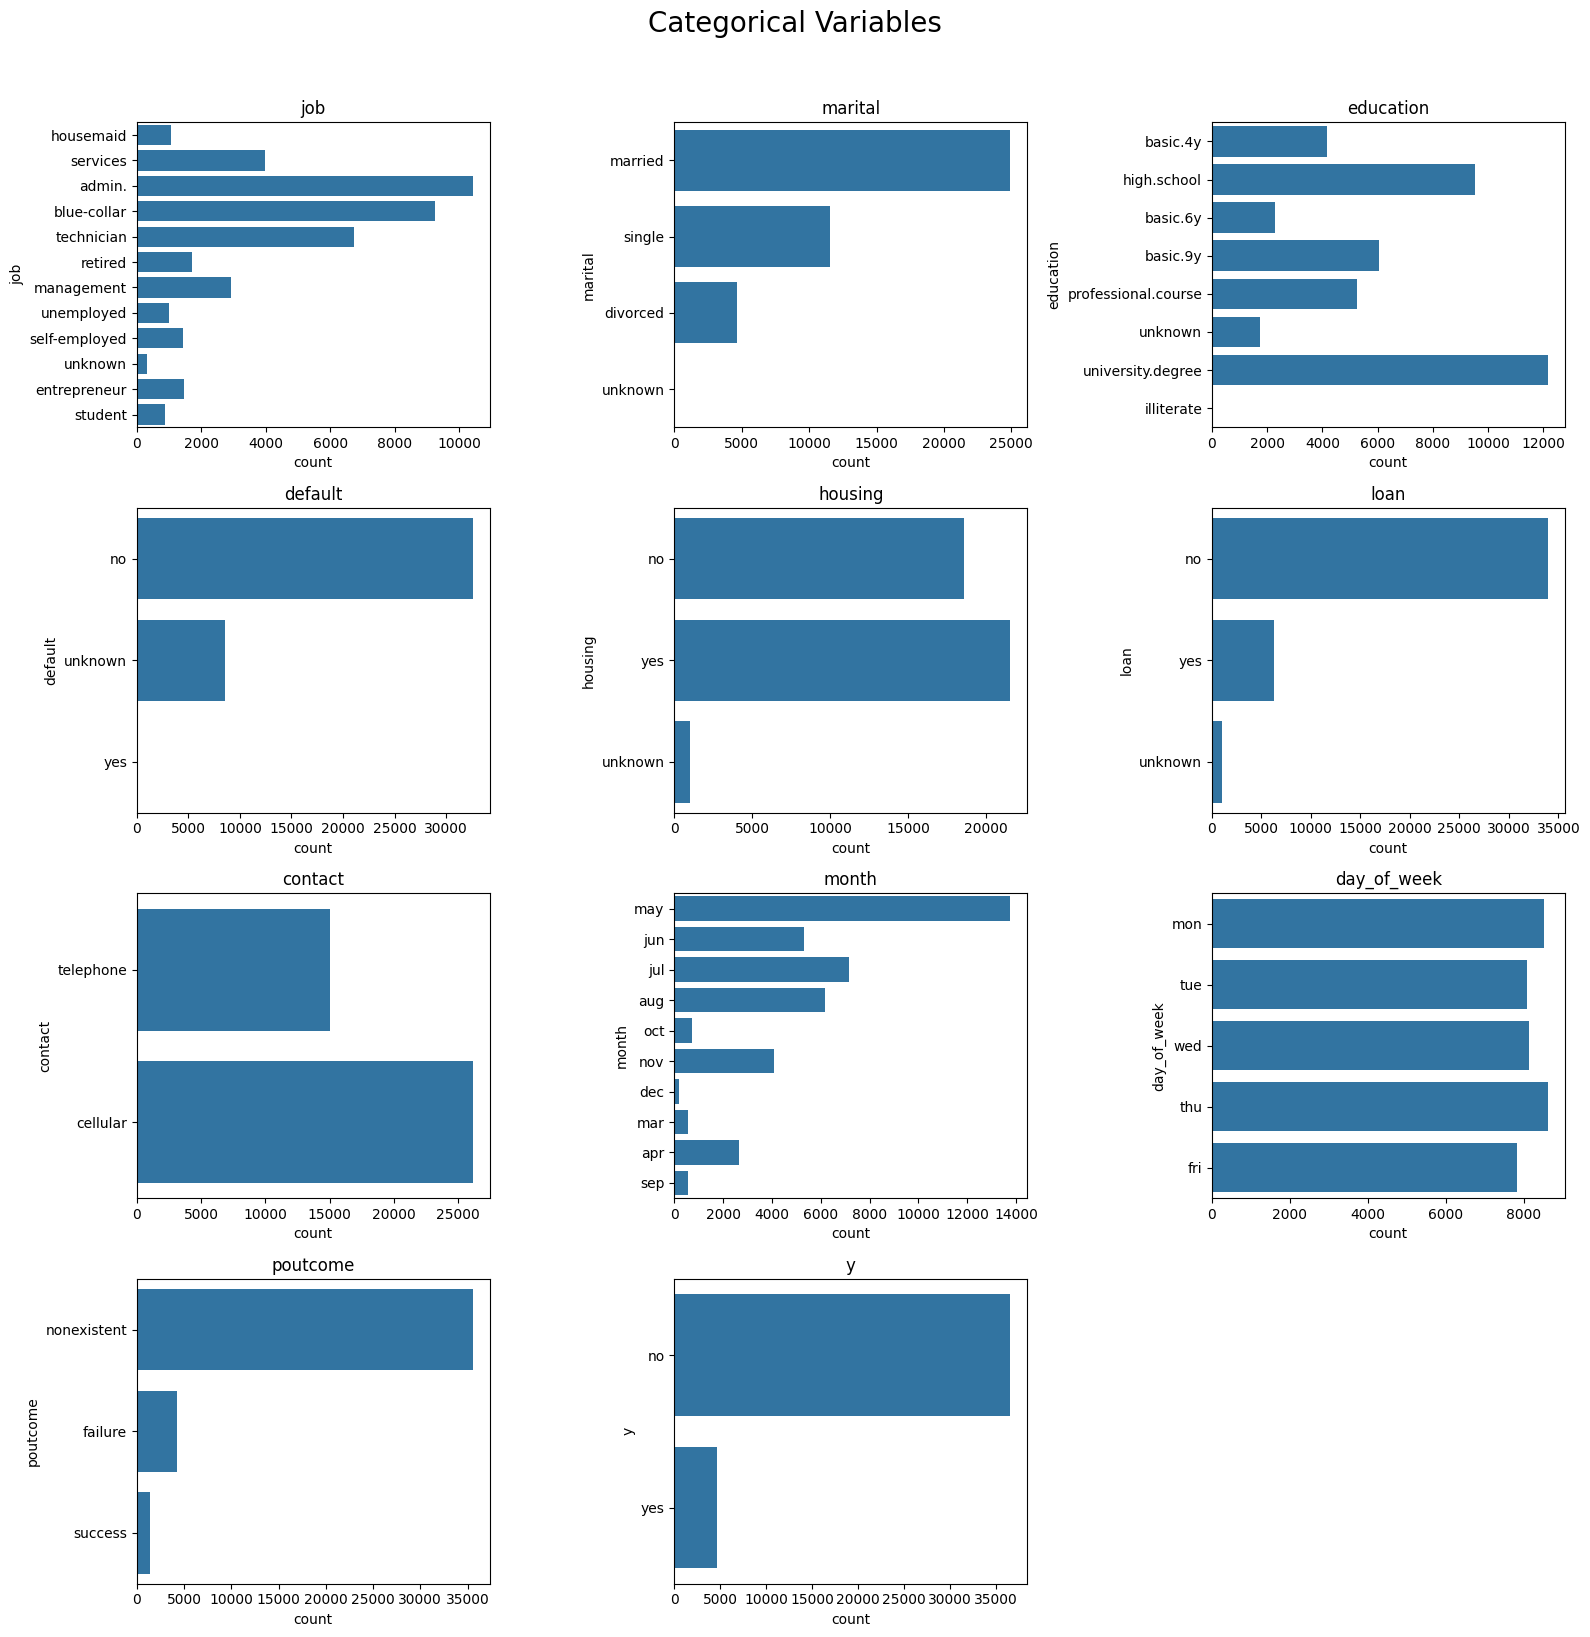

In [10]:
n = len(categorical_vars) # number of categorical variables

cols = 3
rows = math.ceil(n / cols) # automatically determine rows and columns

plt.figure(figsize=(16, rows * 4))

plt.suptitle("Categorical Variables", fontsize=20, y=1.02)

for i, col in enumerate(categorical_vars, start=1):
    plt.subplot(rows, cols, i)
    sns.countplot(data=bank_data_full, y=col)
    plt.title(col)

plt.tight_layout()
plt.show()

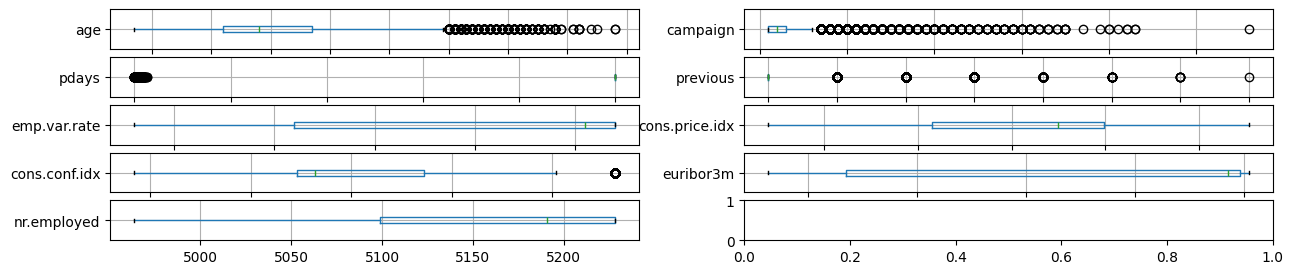

In [11]:
# number of boxes to plot is number of columns in df that are not an object.
columns_in_df = bank_data_full.select_dtypes(exclude='object').shape[1]

#number in columns in plot is 2 and number of rows is number of columns in df/number of columns in plot, rounded upwards
ncols = 2
nrows = math.ceil(columns_in_df/ncols)

fig, axs = plt.subplots(nrows, ncols, figsize=(15, 3) )

axsrow=0
axscol=0

for label, values in bank_data_full.items():
    if values.dtype != object:
        if axscol == 2:
            axsrow = axsrow + 1
            axscol = 0
        bank_data_full.boxplot(column=[label], vert=False, ax=axs[axsrow,axscol])
        axscol = axscol + 1

plt.xticks()
plt.show()    


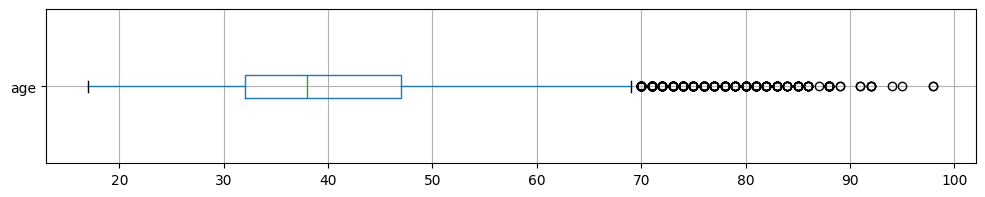

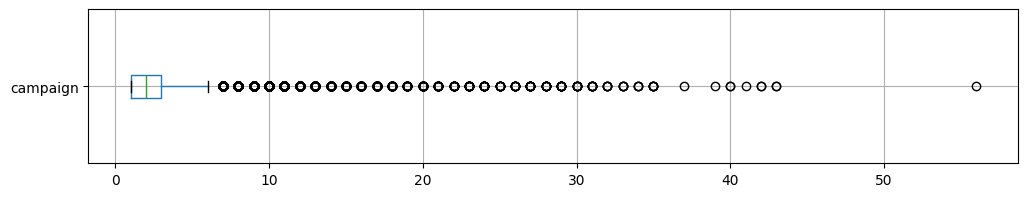

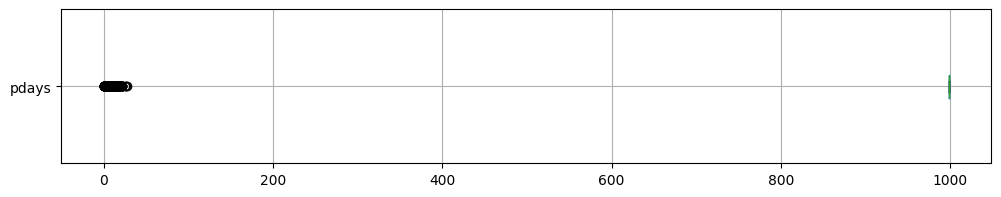

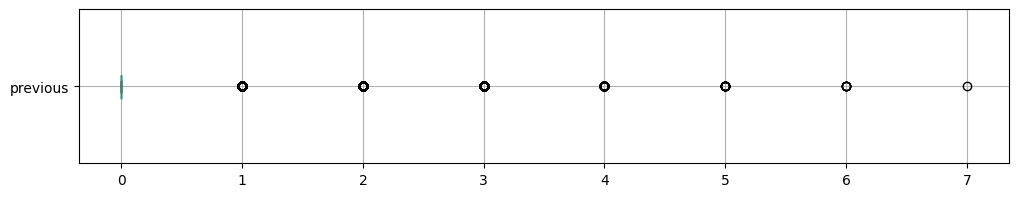

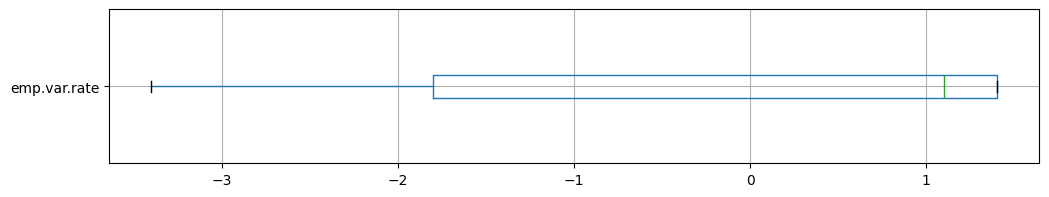

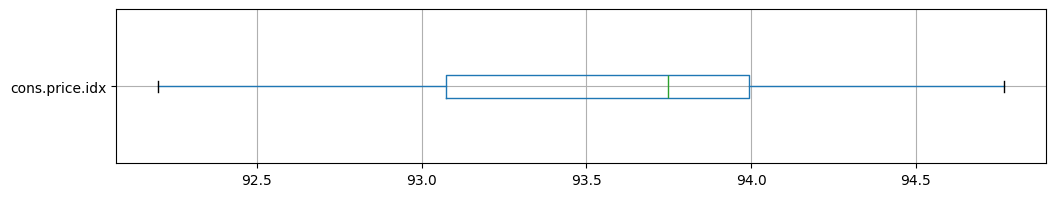

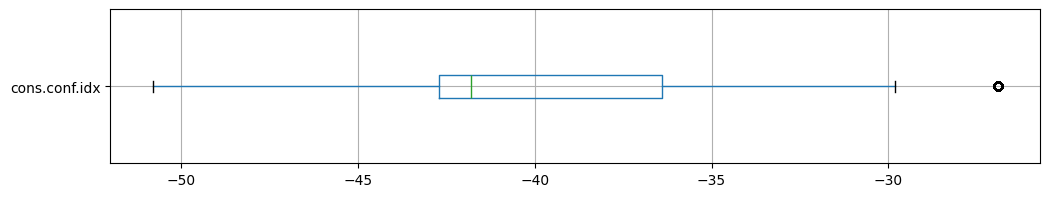

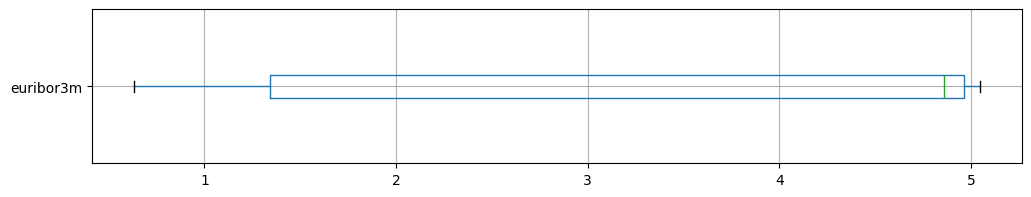

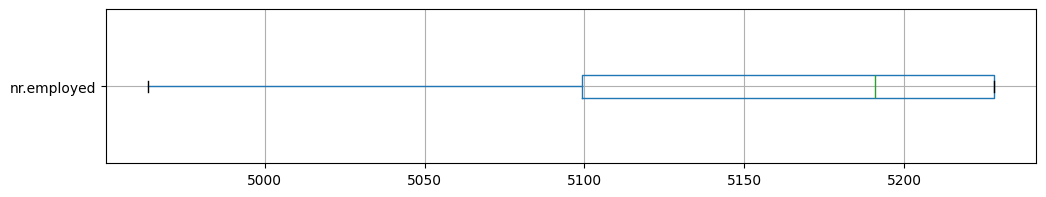

In [12]:
for label, values in bank_data_full.items():
    if values.dtype != object:
        bank_data_full.boxplot(column=[label], vert=False, figsize=(12, 2))
        plt.show()

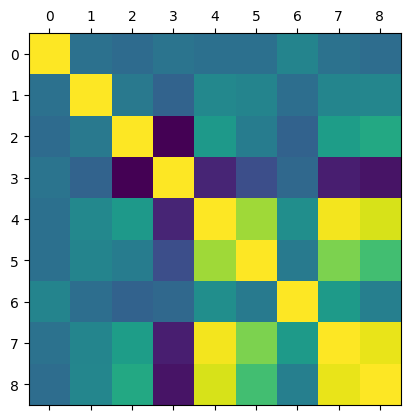

In [13]:
# Is there a correlation between features
# NOTE: this can only be done with numerical features
 
plt.matshow(bank_data_full.select_dtypes(exclude='object').corr())

<Axes: >

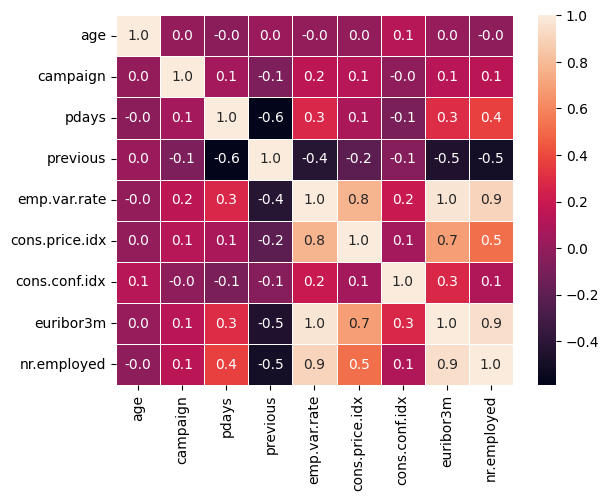

In [14]:
# What ss the correlation between features
# NOTE: this can only be done with numerical features
# NOTE 2: This means that this is not a way to determine a correlation with the target, because the target is yes/no

sns.heatmap(bank_data_full.select_dtypes(exclude='object').corr(), annot=True, linewidth=.5, fmt=".1f")

3 features hve a very high correlation (> 0.9): eurbor3m, emp.var.rate and nr.employed
Options are: 
- leave 2 out 
- combine the 3 to 1
- do nothing

In [15]:
# split the dataframe i X and y
# in doing so, make yes=1 and no=0 (both as integer)
X = bank_data_full.drop("y", axis='columns')
y = bank_data_full["y"].replace(to_replace={'yes': '1', 'no': '0'}).astype(int)

In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  euribor3m       41188 non-null 

In [17]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 41188 entries, 0 to 41187
Series name: y
Non-Null Count  Dtype
--------------  -----
41188 non-null  int64
dtypes: int64(1)
memory usage: 321.9 KB


In [18]:
# Split te dataframe training and testset, using stratify, because yes/no is imbalanced

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape) #checking the shape of the splits
print("Train: ", len(X_train), "&",len(y_train))
print("Test: ", len(X_test), "&",len(y_test))

(32950, 19) (8238, 19) (32950,) (8238,)
Train:  32950 & 32950
Test:  8238 & 8238


## Let's do some standard stuff, before really looking good in detail at the data

In [19]:
cat_pipeline = make_pipeline(OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
num_pipeline = make_pipeline(StandardScaler())

cat_features = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "day_of_week"]
num_features = ["age", "campaign", "pdays", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]

preprocessing = ColumnTransformer([
    ("cat", cat_pipeline, cat_features),
    ("num", num_pipeline, num_features)
    ])

## Doing some training

## Logistic Regression as trial

In [20]:
#LogisticRegression pipeline
log_reg = make_pipeline(preprocessing, LogisticRegression())

In [21]:
# Training without crossvalidation
log_reg.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [22]:
# make a prediction on the test-set
y_test_pred = log_reg.predict(X_test)

In [23]:
# Recall
recall_log_reg = recall_score(y_test, y_test_pred)
print("Recall: ", recall_log_reg)

# Precision
precision_log_reg = precision_score(y_test, y_test_pred)
print("Precision: ", precision_log_reg)

Recall:  0.21875
Precision:  0.6858108108108109


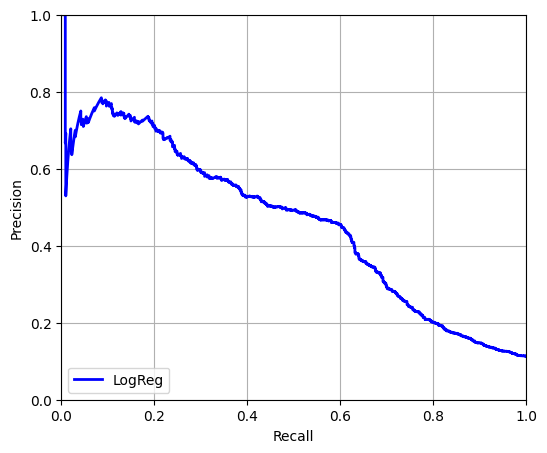

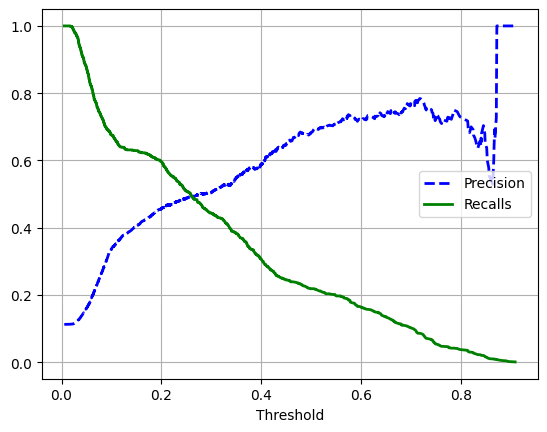

In [24]:
#Draw curves on test set
y_test_proba = log_reg.predict_proba(X_test)

precisions_log_reg, recalls_log_reg, thresholds_log_reg = precision_recall_curve(y_test, y_test_proba[:,1])

plt.figure(figsize=(6, 5))

# recall vs precision
plt.plot(recalls_log_reg, precisions_log_reg, "b-", linewidth=2, label="LogReg")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
plt.show()

# recall and precision vs thresholds
plt.plot(thresholds_log_reg, precisions_log_reg[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds_log_reg, recalls_log_reg[:-1], "g-", label="Recalls", linewidth=2)
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.show()

# With Cross Validation

In [25]:
#LogisticRegression cross validated predict probalities on TRAINING set
y_train_proba_crossval_logreg = cross_val_predict(log_reg, X_train, y_train, cv=5, method="predict_proba")


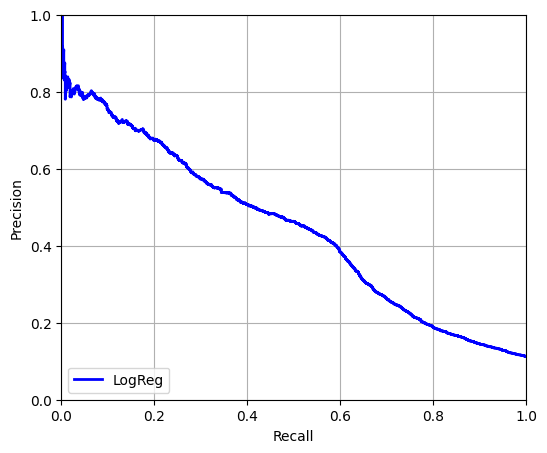

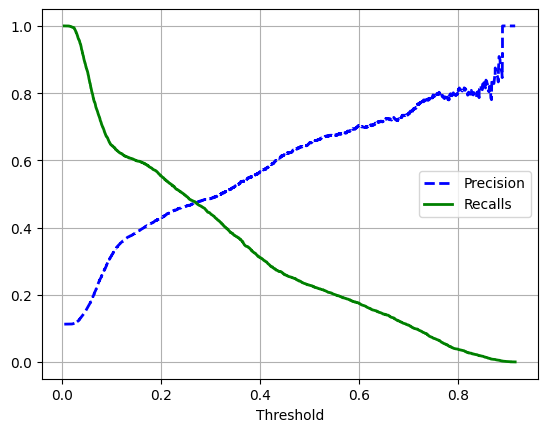

In [26]:
# Draw the Curve(s)
precisions_logreg, recalls_logreg, thresholds_logreg = precision_recall_curve(y_train, y_train_proba_crossval_logreg[:, 1])

plt.figure(figsize=(6, 5))

# recall vs precision
plt.plot(recalls_logreg, precisions_logreg, "b-", linewidth=2, label="LogReg")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
plt.show()

# recall and precision vs thresholds
plt.plot(thresholds_logreg, precisions_logreg[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds_logreg, recalls_logreg[:-1], "g-", label="Recalls", linewidth=2)
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.show()

In [27]:
#LogisticRegression cross validated predict probalities on TEST set
y_test_proba_crossval_logreg = cross_val_predict(log_reg, X_test, y_test, cv=5, method="predict_proba")


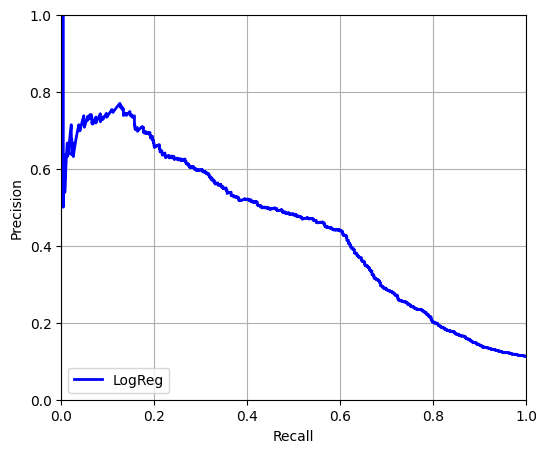

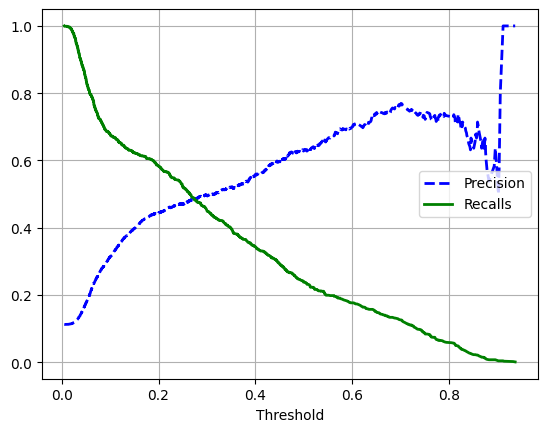

In [28]:
# Draw the Curve(s)
precisions_logreg, recalls_logreg, thresholds_logreg = precision_recall_curve(y_test, y_test_proba_crossval_logreg[:, 1])

plt.figure(figsize=(6, 5))

# recall vs precision
plt.plot(recalls_logreg, precisions_logreg, "b-", linewidth=2, label="LogReg")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
plt.show()

# recall and precision vs thresholds
plt.plot(thresholds_logreg, precisions_logreg[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds_logreg, recalls_logreg[:-1], "g-", label="Recalls", linewidth=2)
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.show()

# Change Pdays and retrain

In [29]:
#Step 1: copy x to X_P
X_p = X.copy()

#Step 2: add column based on Pdays
# Binary indicator
X_p['contacted_before'] = (X_p['pdays'] != 999).astype(int)

#step 3: remove column Pdays
X_p = X_p.drop(columns=['pdays'])

In [30]:
X_p_train, X_p_test, y_p_train, y_p_test = train_test_split(X_p, y, test_size=0.2, random_state=42, stratify=y)
print(X_p_train.shape, X_p_test.shape, y_p_train.shape, y_p_test.shape) #checking the shape of the splits
print("Train: ", len(X_p_train), "&",len(y_p_train))
print("Test: ", len(X_p_test), "&",len(y_p_test))

(32950, 19) (8238, 19) (32950,) (8238,)
Train:  32950 & 32950
Test:  8238 & 8238


In [37]:
cat_pipeline = make_pipeline(OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
num_pipeline = make_pipeline(StandardScaler())

cat_features = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "day_of_week", "contacted_before"]
num_features = ["age", "campaign", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]

preprocessing_p = ColumnTransformer([
    ("cat", cat_pipeline, cat_features),
    ("num", num_pipeline, num_features)
    ])

In [38]:
#Train and draw
log_reg_p = make_pipeline(preprocessing_p, LogisticRegression())

#LogisticRegression cross validated predict probalities on TRAINING set
y_p_train_proba_crossval_logreg = cross_val_predict(log_reg_p, X_p_train, y_p_train, cv=5, method="predict_proba")

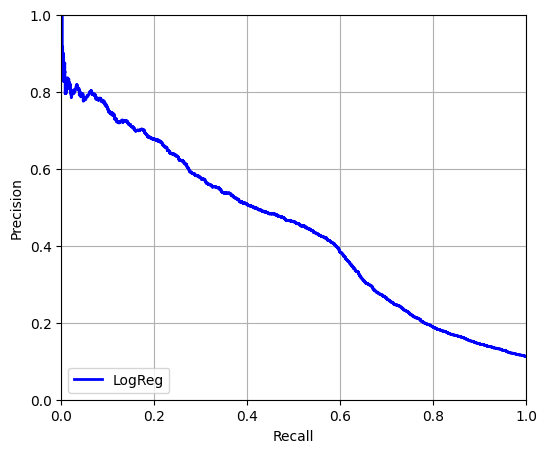

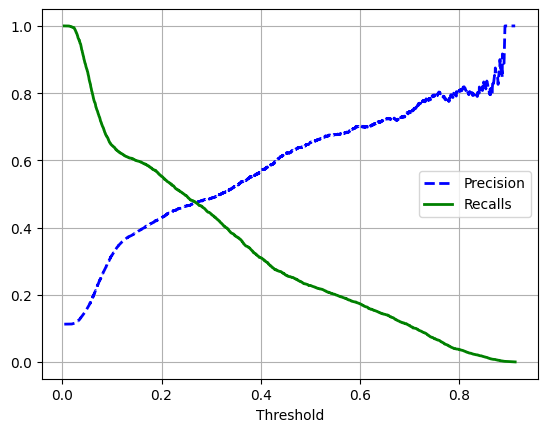

In [39]:
# Draw the Curve(s)
precisions_logreg_p, recalls_logreg_p, thresholds_logreg_p = precision_recall_curve(y_p_train, y_p_train_proba_crossval_logreg[:, 1])

plt.figure(figsize=(6, 5))

# recall vs precision
plt.plot(recalls_logreg_p, precisions_logreg_p, "b-", linewidth=2, label="LogReg")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
plt.show()

# recall and precision vs thresholds
plt.plot(thresholds_logreg_p, precisions_logreg_p[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds_logreg_p, recalls_logreg_p[:-1], "g-", label="Recalls", linewidth=2)
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.show()

KNN
RF 
LogReg